In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
!pip install -U -q kaggle

In [0]:
!mkdir -p ~/.kaggle

In [0]:
from google.colab import files
files.upload()

In [0]:
!cp kaggle.json ~/.kaggle/

In [9]:
!kaggle competitions download -c widsdatathon2019
!ls


  0% 0.00/354k [00:00<?, ?B/s]
100% 354k/354k [00:00<00:00, 48.2MB/s]
 66% 29.0M/44.1M [00:00<00:00, 41.3MB/s]
100% 44.1M/44.1M [00:00<00:00, 88.5MB/s]
 92% 83.0M/90.4M [00:01<00:00, 67.0MB/s]
100% 90.4M/90.4M [00:01<00:00, 87.0MB/s]
 97% 309M/317M [00:03<00:00, 70.2MB/s]
100% 317M/317M [00:04<00:00, 82.5MB/s]
  0% 0.00/134k [00:00<?, ?B/s]
100% 134k/134k [00:00<00:00, 42.3MB/s]
kaggle.json		      sample_data	    traininglabels.csv
leaderboard_holdout_data.zip  SampleSubmission.csv
leaderboard_test_data.zip     train_images.zip


In [0]:
!unzip leaderboard_holdout_data.zip
!unzip leaderboard_test_data.zip
!unzip train_images.zip

In [11]:
!ls

kaggle.json		      leaderboard_test_data.zip  train_images.zip
leaderboard_holdout_data      sample_data		 traininglabels.csv
leaderboard_holdout_data.zip  SampleSubmission.csv
leaderboard_test_data	      train_images


In [0]:
import fastai
from fastai.vision import *

In [0]:
import os
path = Path(os.getcwd())

In [0]:
train = 'train_images'
test =  path/'leaderboard_test_data'
holdout = path/'leaderboard_holdout_data'
sample_sub = path/'SampleSubmission.csv'
labels = path/'traininglabels.csv'

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sn
import keras


Using TensorFlow backend.


In [0]:
data = pd.read_csv(labels)

In [19]:
print(data.shape)
data.head(5)

(15244, 3)


,image_id,has_oilpalm,score
0,img_000002017.jpg,0,0.7895
1,img_000012017.jpg,0,1.0000
2,img_000022017.jpg,0,1.0000
3,img_000072017.jpg,0,1.0000
4,img_000082017.jpg,0,1.0000


In [20]:
data.describe()

,has_oilpalm,score
count,15244.000000,15244.000000
mean,0.061795,0.955769
std,0.240790,0.109367
min,0.000000,0.388700
25%,0.000000,1.000000
50%,0.000000,1.000000
75%,0.000000,1.000000
max,1.000000,1.000000


In [21]:
print ("Number of pics that has oilpalm: ", sum(data.has_oilpalm))
print ("Total pics: ", len(data.has_oilpalm))

Number of pics that has oilpalm:  942
Total pics:  15244


In [0]:
test_names = [f for f in test.iterdir()]
holdout_names = [f for f in holdout.iterdir()]

In [0]:
src = (ImageItemList.from_df(data, path, folder=train)
      .random_split_by_pct(0.2, seed=123)
      .label_from_df('has_oilpalm')
      .add_test(test_names+holdout_names))

In [0]:
train_data =  (src.transform(get_transforms(), size=256)
                  .databunch(bs=16)
                   .normalize(imagenet_stats))

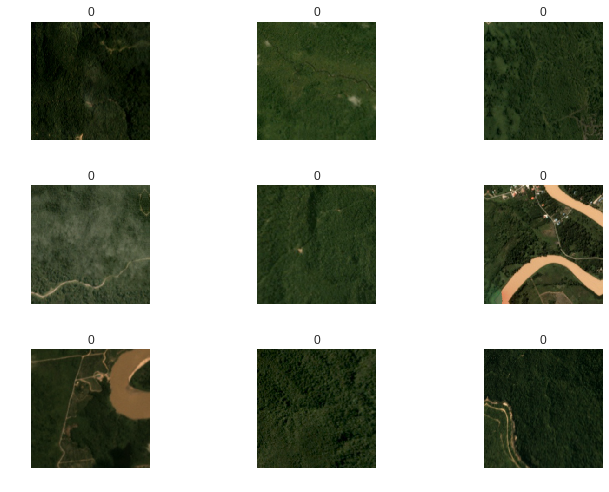

In [25]:
train_data.show_batch(rows=3, figsize=(10,7))

In [26]:
print(train_data.classes)

[0, 1]


# Training: **resnet34**

In [0]:
from sklearn.metrics import roc_auc_score
def auc_score(preds,targets):
    return torch.tensor(roc_auc_score(targets,preds[:,1]))

In [28]:
learn = create_cnn(train_data, models.resnet34, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 71102585.90it/s]


In [29]:
learn.model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (rel

In [30]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,accuracy
1,0.078489,0.040321,0.988189
2,0.057956,0.029583,0.990814
3,0.048698,0.021897,0.992454
4,0.044097,0.019173,0.993766


In [0]:
learn.save('stage-1')

In [32]:
interp = ClassificationInterpretation.from_learner(learn)

losses,idxs = interp.top_losses()

len(train_data.valid_ds)==len(losses)==len(idxs)

True

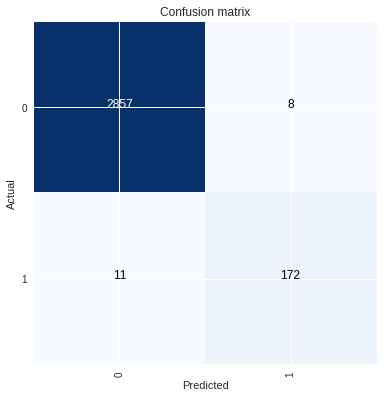

In [33]:
#Stage-1
interp.plot_confusion_matrix()

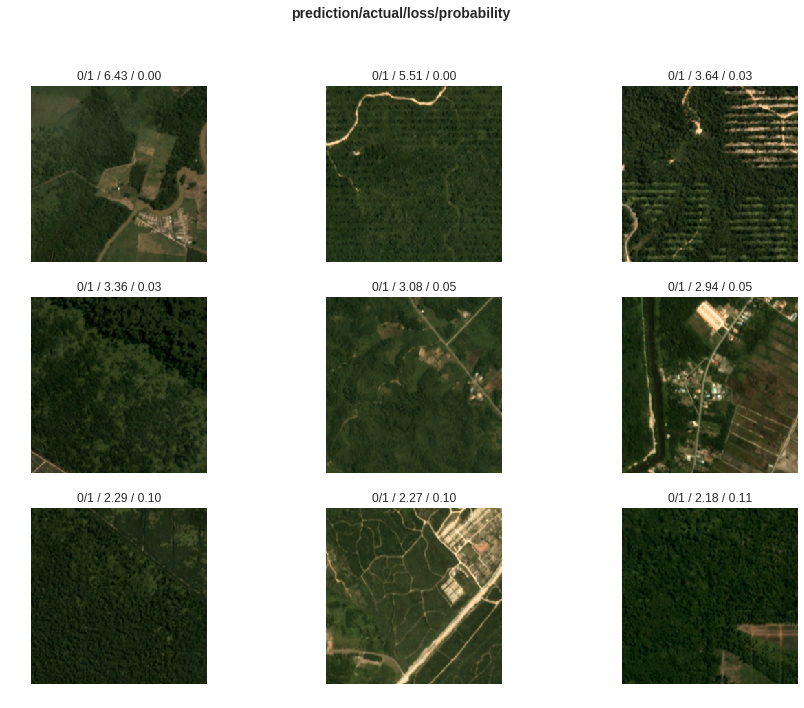

In [34]:
interp.plot_top_losses(9, figsize=(15,11))

In [35]:
learn.unfreeze()
learn.fit_one_cycle(4, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy
1,0.056004,0.037273,0.985564
2,0.051588,0.023767,0.992126
3,0.017936,0.019688,0.991798
4,0.022127,0.020479,0.994423


In [0]:
learn.save('stage-2')

In [37]:
#output stage-2
p,t = learn.get_preds()
auc_score(p,t)

tensor(0.9989)

In [0]:
p,t = learn.get_preds(ds_type=DatasetType.Test)

In [39]:
p = to_np(p)
p.shape

(6534, 2)

In [40]:
ids = np.array([f.name for f in (test_names+holdout_names)])
ids.shape

(6534,)

In [0]:
data_sample = pd.read_csv(sample_sub)

In [0]:
submission = pd.DataFrame(np.stack([ids, p[:,1]], axis=1), columns=data_sample.columns)

In [0]:
submission.to_csv(path/'submission2.csv', index=False)

In [0]:
files.download('submission2.csv')